# Dimensionality Reduction

* Reducing dimensionality does cause some information loss, just like compressing an image to JPEG can degrade its quality, so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain, so first try to train your system with the original data before considering using dimensionality reduction.

# A. The Curse of Dimensionality:

* Many Things behave differently in high-dimensional space.
    * If you pick a random point in a unit square (a 1x1 square), it will have only about 0.4% chance of being located less than 0.001 from the border.( it is very unlikely that a random point will be “extreme” along any dimension). If you pick a random point in a 10,000 dimensional unit hypercube, this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.
    * If you pick 2 points randomly in a unit square, the distance between these 2 points will be on average, roughly 0.52. If you pick 2 random points in a 3D unit cube, the average distance will be roughly 0.66. In a 1,000,000 dimensional unit hypercube, the average distance will be about 408.25.

* Since there are plenty of space in high dimensions, high-dimensional datasets are at risk of being sparse,
    * Most training instances are likely to be far away from each other.
    * A new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations.
    * The more dimensions the training set has, the greater the risk of overfitting it.

* One solution to the curse of dimensionality is to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

# B. Main Approaches for Dimensionality Reduction:

### B.1. Projection:

* In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

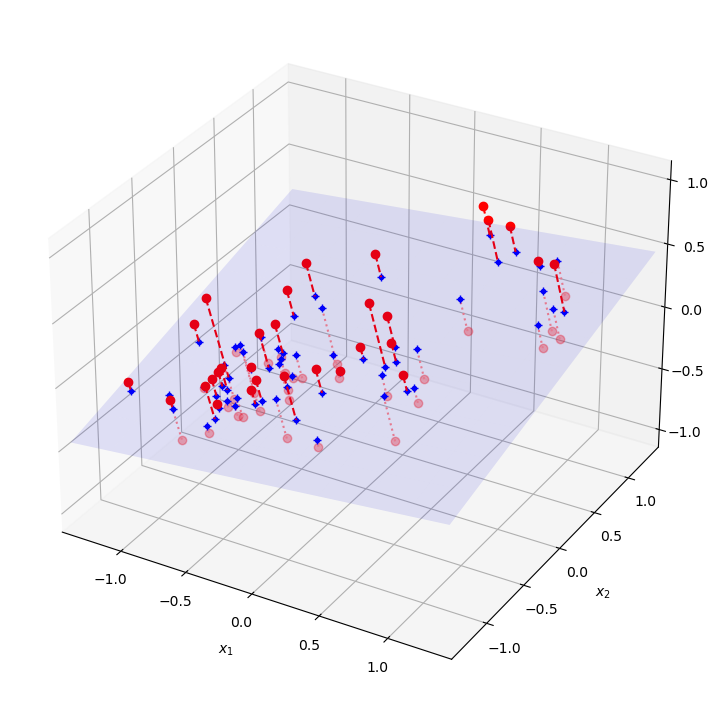

In [1]:
# Create a 3D dataset lying close to a 2D subspace

import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  
X += 0.28 * np.random.randn(m, 3)  
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  


pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  
X3D_inv = pca.inverse_transform(X2D)  
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")


ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1]);

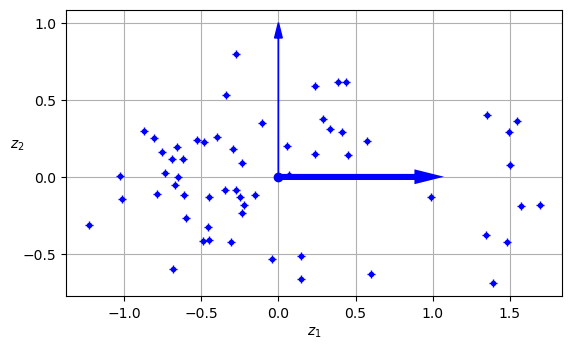

In [2]:
# New 2d Datset after projection
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True);